# Import necessary libraries

In [15]:
import numpy as np
import pandas as pd
import requests
import re
import matplotlib.pyplot as plt

# Fetching data from Investing.com

In [16]:
def fetch_from_investing(URL):

    
    HDRS = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/122.0 Safari/537.36",
        "Accept-Language": "en-US,en;q=0.9",
    }

    def parse_investing_hist(url=URL, headers=HDRS):
        html = requests.get(url, headers=headers, timeout=30).text
        tables = pd.read_html(html, flavor="lxml")  # all tables, any locale
        # column name normalizer
        def norm_cols(df):
            # flatten MultiIndex if present
            if isinstance(df.columns, pd.MultiIndex):
                df.columns = [" ".join([str(x) for x in tup if str(x)!='nan']).strip()
                            for tup in df.columns]
            df.columns = [c.strip().lower().replace("%","%").replace(" ", "_") for c in df.columns]
            return df

        # candidate header translations
        name_map = {
            "fecha":"date", "date":"date",
            "precio":"price", "price":"price",
            "apertura":"open", "open":"open",
            "máximo":"high", "maximo":"high", "high":"high",
            "mínimo":"low", "minimo":"low", "low":"low",
            "volumen":"volume", "volume":"volume",
            "var._%":"change_%", "variación_%":"change_%", "change_%":"change_%", "chg_%":"change_%"
        }

        for t in tables:
            t = norm_cols(t.copy())
            # try to rename known headers
            for k,v in list(name_map.items()):
                if k in t.columns and v not in t.columns:
                    t = t.rename(columns={k:v})

            # fallback: detect a date-like first column
            if "date" not in t.columns:
                first = t.columns[0]
                # keep only rows that look like dates
                mask = t[first].astype(str).str.contains(r"\d{1,2}/\d{1,2}/\d{2,4}", na=False)
                if mask.any():
                    t = t.loc[mask].rename(columns={first:"date"})

            if "date" not in t.columns:
                continue  # not the right table

            # keep plausible price table (has at least price/open/high/low or price+change)
            if not ({"price","open","high","low"} & set(t.columns)):
                continue

            # clean rows with actual dates
            t = t[t["date"].astype(str).str.contains(r"\d", na=False)].copy()

            # types
            t["date"] = pd.to_datetime(t["date"], errors="coerce", dayfirst=False)
            num_cols = [c for c in ["price","open","high","low","volume","change_%"] if c in t.columns]
            for c in num_cols:
                s = t[c].astype(str)
                # remove thousands separators and percent signs
                s = s.str.replace("%","", regex=False)
                s = s.str.replace(",","").str.replace("\u202f","")
                # handle suffixes like 'K','M'
                def to_num(x):
                    m = re.fullmatch(r"(-?\d+(?:\.\d+)?)([KkMmBb])?", x.strip())
                    if not m: 
                        return pd.to_numeric(x, errors="coerce")
                    val, suf = m.groups()
                    val = float(val)
                    mult = {"K":1e3,"k":1e3,"M":1e6,"m":1e6,"B":1e9,"b":1e9}.get(suf,1.0)
                    return val*mult
                t[c] = s.map(to_num)

            t = t.sort_values("date").reset_index(drop=True)
            # standardize column order  
            want = [c for c in ["date","price","open","high","low","volume","change_%"] if c in t.columns]
            return t[want]

        raise RuntimeError("Historical table not found. Page structure or consent wall blocked parsing.")

    df = parse_investing_hist()
    # make date the index
    df = df.set_index("date").sort_index()

    return df


# SOFR

In [17]:

SOFR_rate = [4.34, 4.34, 4.39, 4.39, 4.41, 4.42, 4.40, 4.40, 4.39, 4.41, 4.41]

# Remove the non-bank day 2025-09-01
non_bank_day = ['2025-09-01']

dates = pd.date_range(start='2025-08-28', periods=len(SOFR_rate) + len(non_bank_day), freq='B')

# Filter out the non-bank day from dates and SOFR
dates = dates[~dates.isin(non_bank_day)]
SOFR_rate = [rate for date, rate in zip(dates, SOFR_rate) if date != non_bank_day]

# Update SOFR_series
SOFR = pd.Series(SOFR_rate, index=dates)

C:\Users\herie\AppData\Local\Temp\ipykernel_30568\2588569263.py:9: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  dates = dates[~dates.isin(non_bank_day)]


In [18]:
SOFR

2025-08-28    4.34
2025-08-29    4.34
2025-09-02    4.39
2025-09-03    4.39
2025-09-04    4.41
2025-09-05    4.42
2025-09-08    4.40
2025-09-09    4.40
2025-09-10    4.39
2025-09-11    4.41
2025-09-12    4.41
dtype: float64

In [19]:
start_date = SOFR.index[0]
end_date = SOFR.index[-1]

In [20]:
# keep the SOFR from 5sep until max
SOFR = SOFR[(SOFR.index >= '2025-09-05')]

In [21]:
SOFR

2025-09-05    4.42
2025-09-08    4.40
2025-09-09    4.40
2025-09-10    4.39
2025-09-11    4.41
2025-09-12    4.41
dtype: float64

In [22]:
dates = SOFR.index

In [23]:
SOFR_daily = (1 + SOFR/100)**(1/360) - 1  # daily compounding
SOFR_daily

2025-09-05    0.000120
2025-09-08    0.000120
2025-09-09    0.000120
2025-09-10    0.000119
2025-09-11    0.000120
2025-09-12    0.000120
dtype: float64

# Silver

## Stock Price

In [24]:
silver = fetch_from_investing("https://www.investing.com/currencies/xag-usd-historical-data")

C:\Users\herie\AppData\Local\Temp\ipykernel_30568\338722890.py:11: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tables = pd.read_html(html, flavor="lxml")  # all tables, any locale


In [25]:
silver

,price,open,high,low,change_%
date,,,,,
2025-08-15,38.0150,38.0096,38.1350,37.6766,0.00
2025-08-18,38.0350,38.0350,38.2850,37.8176,0.05
2025-08-19,37.3950,38.0357,38.1750,37.2665,-1.68
2025-08-20,37.9087,37.3495,37.9650,36.9556,1.37
2025-08-21,38.1900,37.8729,38.2550,37.5262,0.74
2025-08-22,38.8475,38.1456,39.0950,37.6868,1.72
2025-08-25,38.5750,38.9319,39.0250,38.5222,-0.70
2025-08-26,38.6150,38.5811,38.8850,38.3275,0.10
2025-08-27,38.6385,38.5839,38.7249,38.0774,0.06


In [26]:
silver_price = silver.iloc[:,0]
silver_price = silver_price[silver_price.index.isin(dates)]
silver_price    

date
2025-09-05    41.005
2025-09-08    41.355
2025-09-09    40.905
2025-09-10    41.170
2025-09-11    41.585
2025-09-12    42.195
Name: price, dtype: float64

## Futures Contract Price

In [27]:
SIZ25_settle = [41.902-.35, 41.902, 41.341, 41.6, 42.149, 42.83]
SIZ25_expiration_date = pd.to_datetime("2025-12-29")
SIZ25_days_to_exp = (SIZ25_expiration_date - dates[-1]).days
SIZ25 = pd.Series(SIZ25_settle, index=dates)
SIZ25

2025-09-05    41.552
2025-09-08    41.902
2025-09-09    41.341
2025-09-10    41.600
2025-09-11    42.149
2025-09-12    42.830
dtype: float64

## Horizon

In [28]:
SIZ25_days_to_exp = []

for day in range(len(dates)):
    SIZ25_days_to_exp.append((SIZ25_expiration_date - dates[day]).days)

SIZ25_days_to_exp = pd.Series(SIZ25_days_to_exp, index=dates)
SIZ25_days_to_exp

2025-09-05    115
2025-09-08    112
2025-09-09    111
2025-09-10    110
2025-09-11    109
2025-09-12    108
dtype: int64

## Dividens

In [29]:
silver_dividends = pd.Series(np.zeros(len(dates)), index=dates)
silver_dividends

2025-09-05    0.0
2025-09-08    0.0
2025-09-09    0.0
2025-09-10    0.0
2025-09-11    0.0
2025-09-12    0.0
dtype: float64

## Theoretical Futures Price

In [30]:
theoretical_price = silver_price * np.exp((SOFR_daily-silver_dividends) * SIZ25_days_to_exp)
theoretical_price

date
2025-09-05    41.575504
2025-09-08    41.912764
2025-09-09    41.451737
2025-09-10    41.714067
2025-09-11    42.131967
2025-09-12    42.744866
dtype: float64

## Difference between Theoretical and Market Price

In [31]:
SIZ25_difference = SIZ25 - theoretical_price
SIZ25_difference    

2025-09-05   -0.023504
2025-09-08   -0.010764
2025-09-09   -0.110737
2025-09-10   -0.114067
2025-09-11    0.017033
2025-09-12    0.085134
dtype: float64

## Risk Premium

In [32]:
SIZ25_risk_premium = SIZ25_settle / silver_price - 1
SIZ25_risk_premium

date
2025-09-05    0.013340
2025-09-08    0.013227
2025-09-09    0.010659
2025-09-10    0.010444
2025-09-11    0.013563
2025-09-12    0.015049
Name: price, dtype: float64

## Create a DataFrame with all the information

In [33]:
SILVER = pd.DataFrame({
    "SOFR Rate": SOFR,
    "Horizon (days)": SIZ25_days_to_exp,
    "Silver Price": silver_price,
    "Market Settlement": SIZ25,
    "Theoretical Price": theoretical_price,
    "Difference": SIZ25_difference,
    "Risk Premium": SIZ25_risk_premium
})
SILVER


,SOFR Rate,Horizon (days),Silver Price,Market Settlement,Theoretical Price,Difference,Risk Premium
2025-09-05,4.42,115,41.005,41.552,41.575504,-0.023504,0.013340
2025-09-08,4.40,112,41.355,41.902,41.912764,-0.010764,0.013227
2025-09-09,4.40,111,40.905,41.341,41.451737,-0.110737,0.010659
2025-09-10,4.39,110,41.170,41.600,41.714067,-0.114067,0.010444
2025-09-11,4.41,109,41.585,42.149,42.131967,0.017033,0.013563
2025-09-12,4.41,108,42.195,42.830,42.744866,0.085134,0.015049


## Plot the table for LaTeX

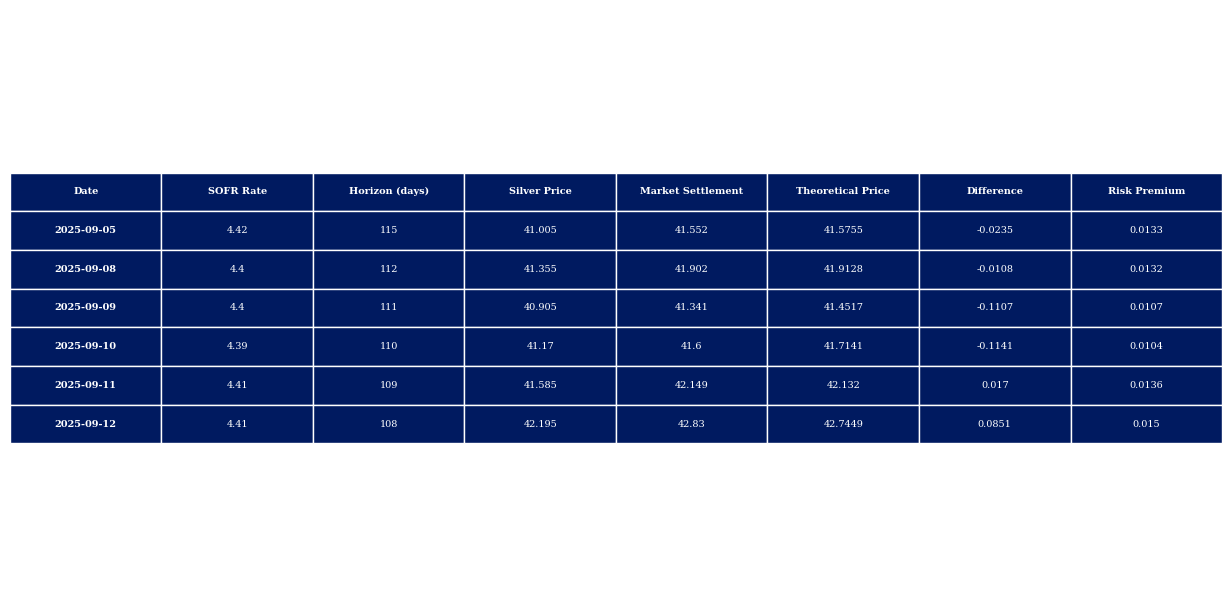

In [34]:
# Export the dataframe to a PDF with the index included
import matplotlib.pyplot as plt
import pandas as pd

import style
style.mpl_apply()
fig, ax = plt.subplots(figsize=(12, 6))
ax.axis('tight')
ax.axis('off')

# Include the index in the table
table_data = SILVER.reset_index()  # Reset index to include it as a column

# Rename the index column
table_data = table_data.rename(columns={"index": "Date"})
# show only the days, not the time
table_data['Date'] = table_data['Date'].dt.date

cell_text = table_data.round(4).values
col_labels = table_data.columns

the_table = ax.table(
    cellText=cell_text,
    colLabels=col_labels,
    loc='center',
    cellLoc='center'
)
the_table.auto_set_font_size(True)
the_table.set_fontsize(10)
the_table.scale(1.2, 1.8)

# Apply styles to the table
for key, cell in the_table.get_celld().items():
    cell.set_facecolor('#001a60')  # Set background color to blue
    cell.set_edgecolor('white')  # Set border color to white
    cell.set_text_props(color='white')  # Set font color to white

    # Make the Date and first column bold
    if key[1] == 0:  # Date column
        cell.set_text_props(weight='bold')
    # Make the first row (header) bold
    if key[0] == 0:  # Header row
        cell.set_text_props(weight='bold')

# Adjust layout to reduce margins
plt.tight_layout(pad=0.1)

plt.savefig("latex/figures/silver__pricing_over_the_week.pdf", bbox_inches='tight', pad_inches=0.2)
plt.show()

## Plot the difference between Theoretical and Market Price

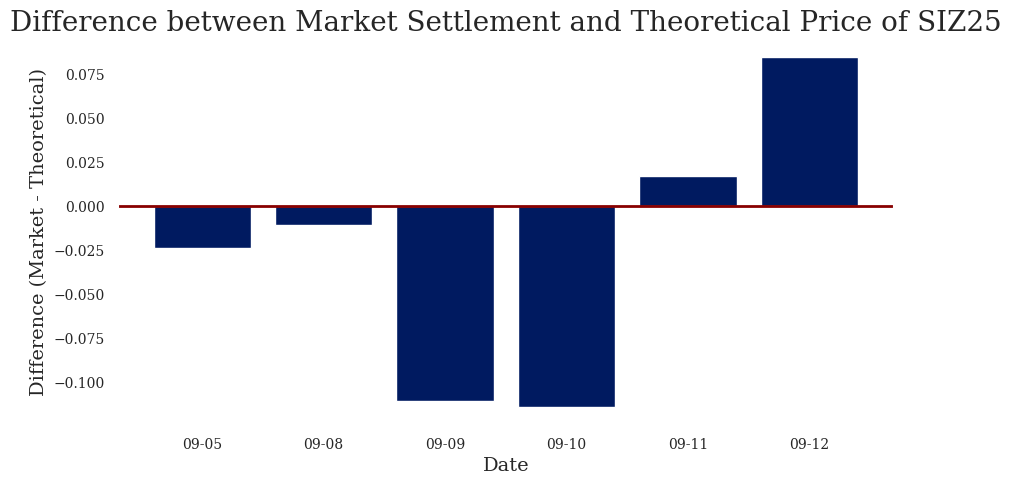

In [35]:
# plot a bar chart of the difference between theoretical and market price
plt.figure(figsize=(10, 5))
plt.bar(SILVER.index.strftime('%m-%d'), SILVER['Difference'], color='#001a60')
plt.xlabel('Date')
plt.ylabel('Difference (Market - Theoretical)')
plt.title('Difference between Market Settlement and Theoretical Price of SIZ25')
plt.axhline(0, color='#880000', linestyle='-', linewidth=2)
plt.grid(False)
plt.savefig("latex/figures/silver_difference.pdf", bbox_inches='tight', pad_inches=0.2)
plt.show()

## Plot the risk premium

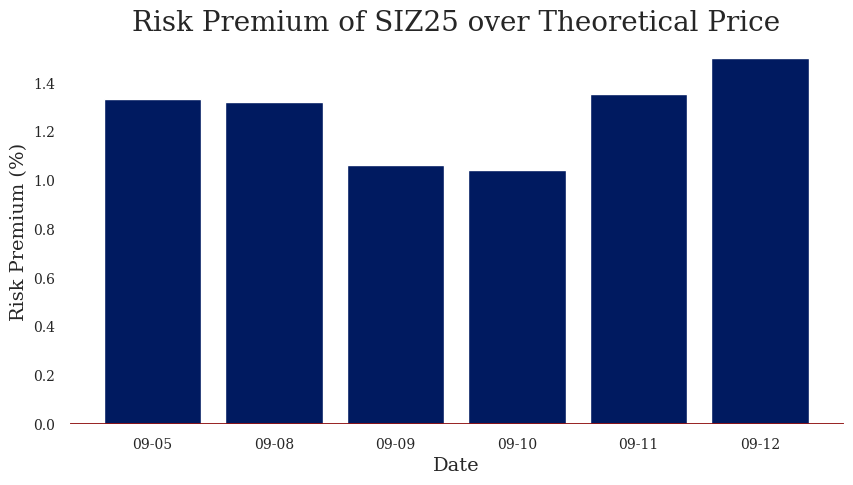

In [36]:
# plot the risk premium
plt.figure(figsize=(10, 5))
plt.bar(SILVER.index.strftime('%m-%d'), SILVER['Risk Premium']*100, color='#001a60')
plt.xlabel('Date')
plt.ylabel('Risk Premium (%)')
plt.title('Risk Premium of SIZ25 over Theoretical Price')
plt.axhline(0, color='#880000', linestyle='-', linewidth=2)
plt.grid(False)
plt.savefig("latex/figures/silver_risk_premium.pdf", bbox_inches='tight', pad_inches=0.2)
plt.show()

# Generalize the function for other derivatives

In [37]:
def pricing_derivatives_in_time(SOFR, spot, name, futures_contract_settle, futures_contract_expiration_date, 
                                spot_dividends=None):
    """
    futures_contract_settle = [41.902-.35, 41.902, 41.341, 41.6, 42.149, 42.83]
    futures_contract_expiration_date = pd.to_datetime("2025-12-29")
    """
    
    dates = SOFR.index

    SOFR_daily = (1 + SOFR/100)**(1/360) - 1 
    SOFR_daily

    spot_price = spot.iloc[:,0]
    spot_price = spot_price[spot_price.index.isin(dates)]

    futures_contract_expiration_date = pd.to_datetime(futures_contract_expiration_date)
    futures_contract_days_to_exp = (futures_contract_expiration_date - dates[-1]).days
    futures_contract = pd.Series(futures_contract_settle, index=dates)


    futures_contract_days_to_exp = []
    for day in range(len(dates)):
        futures_contract_days_to_exp.append((futures_contract_expiration_date - dates[day]).days)
    futures_contract_days_to_exp = pd.Series(futures_contract_days_to_exp, index=dates)

    if spot_dividends is None:
        spot_dividends = pd.Series(np.zeros(len(dates)), index=dates)
    else :
        spot_dividends = spot_dividends[spot_dividends.index.isin(dates)]

    theoretical_price = spot_price * np.exp((SOFR_daily-spot_dividends) * futures_contract_days_to_exp)

    futures_contract_difference = futures_contract - theoretical_price
    futures_contract_risk_premium = futures_contract_settle / spot_price - 1

    spot = pd.DataFrame({
        "SOFR Rate": SOFR,
        "Horizon (days)": futures_contract_days_to_exp,
        f"{name} Price": spot_price,
        "Market Settlement": futures_contract,
        "Theoretical Price": theoretical_price,
        "Difference": futures_contract_difference,
        "Risk Premium": futures_contract_risk_premium
    })

    # plot the table for LaTeX
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.axis('tight')
    ax.axis('off')

    table_data = spot.reset_index() 
    table_data = table_data.rename(columns={"index": "Date"})
    table_data['Date'] = table_data['Date'].dt.date

    cell_text = table_data.round(4).values
    col_labels = table_data.columns

    the_table = ax.table(
        cellText=cell_text,
        colLabels=col_labels,
        loc='center',
        cellLoc='center'
    )
    the_table.auto_set_font_size(True)
    the_table.set_fontsize(10)
    the_table.scale(1.2, 1.8)

    # Apply styles to the table
    for key, cell in the_table.get_celld().items():
        cell.set_facecolor('#001a60')  # Set background color to blue
        cell.set_edgecolor('white')  # Set border color to white
        cell.set_text_props(color='white')  # Set font color to white

        # Make the Date and first column bold
        if key[1] == 0:  # Date column
            cell.set_text_props(weight='bold')
        # Make the first row (header) bold
        if key[0] == 0:  # Header row
            cell.set_text_props(weight='bold')

    # Adjust layout to reduce margins
    plt.tight_layout(pad=0.1)

    plt.savefig(f"latex/figures/{name}_pricing_over_the_week.pdf", bbox_inches='tight', pad_inches=0.2)
    plt.show()

    # plot a bar chart of the difference between theoretical and market price
    plt.figure(figsize=(10, 5))
    plt.bar(spot.index.strftime('%m-%d'), spot['Difference'], color='#001a60')
    plt.xlabel('Date')
    plt.ylabel('Difference (Market - Theoretical)')
    plt.title('Difference between Market Settlement and Theoretical Price of futures_contract')
    plt.axhline(0, color='#880000', linestyle='-', linewidth=2)
    plt.grid(False)
    plt.savefig(f"latex/figures/{name}_difference.pdf", bbox_inches='tight', pad_inches=0.2)
    plt.show()

    # plot the risk premium
    plt.figure(figsize=(10, 5))
    plt.bar(spot.index.strftime('%m-%d'), spot['Risk Premium']*100, color='#001a60')
    plt.xlabel('Date')
    plt.ylabel('Risk Premium (%)')
    plt.title('Risk Premium of futures_contract over Theoretical Price')
    plt.axhline(0, color='#880000', linestyle='-', linewidth=2)
    plt.grid(False)
    plt.savefig(f"latex/figures/{name}_risk_premium.pdf", bbox_inches='tight', pad_inches=0.2)
    plt.show()

    return spot

# MXN/USD

## Futures Contract Price

In [38]:
# MXN/USD (MPU25)
MPU25_settle = [.05357 - .00015, .05357, .05367, .05378, .05409, .05421]
MPU25 = pd.Series(MPU25_settle, index=dates)
MXNUSD_expiration_date = "2025-09-15"
MPU25

2025-09-05    0.05342
2025-09-08    0.05357
2025-09-09    0.05367
2025-09-10    0.05378
2025-09-11    0.05409
2025-09-12    0.05421
dtype: float64

## Spot Price

In [39]:
mxnusd = fetch_from_investing("https://www.investing.com/currencies/mxn-usd-historical-data")
mxnusd

C:\Users\herie\AppData\Local\Temp\ipykernel_30568\338722890.py:11: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tables = pd.read_html(html, flavor="lxml")  # all tables, any locale


,price,open,high,low,change_%
date,,,,,
2025-08-15,0.05335,0.05317,0.05355,0.05312,0.28
2025-08-18,0.05323,0.05343,0.05345,0.05299,-0.22
2025-08-19,0.05314,0.05324,0.05332,0.05299,-0.17
2025-08-20,0.05328,0.05314,0.05341,0.05305,0.26
2025-08-21,0.05332,0.05321,0.05340,0.05314,0.08
2025-08-22,0.05375,0.05335,0.05386,0.05322,0.81
2025-08-25,0.05355,0.05381,0.05391,0.05347,-0.37
2025-08-26,0.05358,0.05355,0.05372,0.05345,0.06
2025-08-27,0.05358,0.05357,0.05364,0.05319,0.00


## Pricing

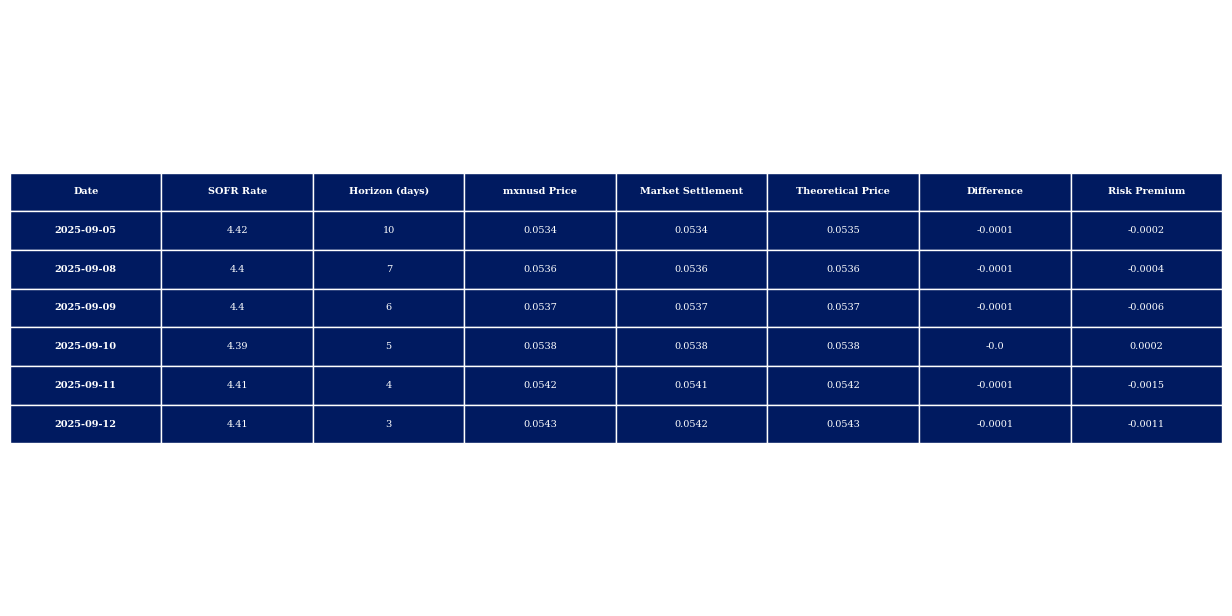

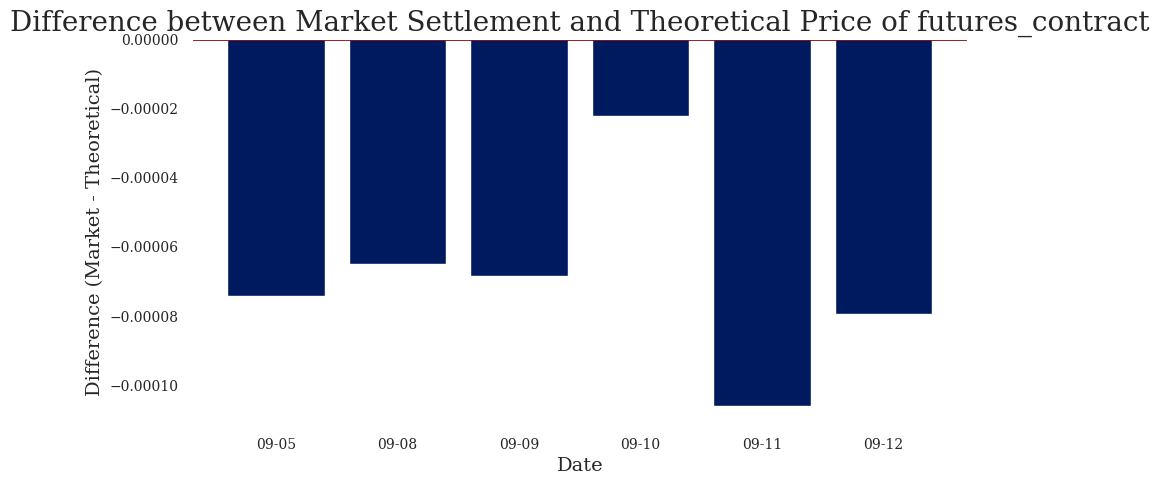

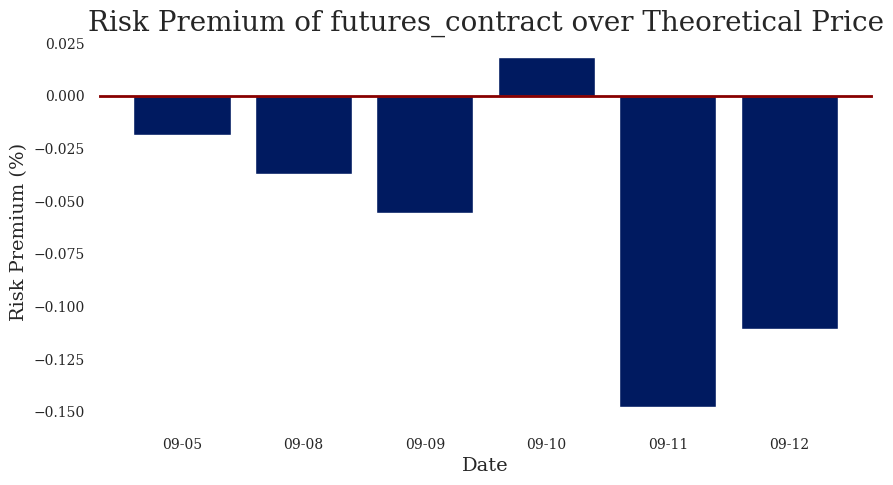

,SOFR Rate,Horizon (days),mxnusd Price,Market Settlement,Theoretical Price,Difference,Risk Premium
2025-09-05,4.42,10,0.05343,0.05342,0.053494,-0.000074,-0.000187
2025-09-08,4.40,7,0.05359,0.05357,0.053635,-0.000065,-0.000373
2025-09-09,4.40,6,0.05370,0.05367,0.053739,-0.000069,-0.000559
2025-09-10,4.39,5,0.05377,0.05378,0.053802,-0.000022,0.000186
2025-09-11,4.41,4,0.05417,0.05409,0.054196,-0.000106,-0.001477
2025-09-12,4.41,3,0.05427,0.05421,0.054290,-0.000080,-0.001106


In [40]:
MXNUSD = pricing_derivatives_in_time(SOFR, mxnusd, "mxnusd", MPU25_settle, MXNUSD_expiration_date)
MXNUSD

# Crude Oil

## Futures Contract Price

In [41]:
# Crude Oil Futures (CLV25)
CLV25_settle = [62.26-.39, 62.26, 62.63, 63.67, 62.37, 62.69]
CLV25_expiration_date = "2025-09-22"
CLV25 = pd.Series(CLV25_settle, index=dates)
CLV25

2025-09-05    61.87
2025-09-08    62.26
2025-09-09    62.63
2025-09-10    63.67
2025-09-11    62.37
2025-09-12    62.69
dtype: float64

## Spot Price

In [42]:
wti = fetch_from_investing("https://www.investing.com/commodities/crude-oil-historical-data")
wti

C:\Users\herie\AppData\Local\Temp\ipykernel_30568\338722890.py:11: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tables = pd.read_html(html, flavor="lxml")  # all tables, any locale


,price,open,high,low,change_%
date,,,,,
2025-08-15,62.80,63.91,64.15,62.68,-1.81
2025-08-18,63.42,63.00,63.79,62.18,0.99
2025-08-19,62.35,63.27,63.39,62.25,-1.69
2025-08-20,63.21,62.60,63.55,62.39,1.38
2025-08-21,63.52,62.85,63.67,62.52,0.49
2025-08-22,63.66,63.50,63.93,63.31,0.22
2025-08-25,64.80,63.88,65.10,63.53,1.79
2025-08-26,63.25,64.75,64.76,63.13,-2.39
2025-08-27,64.15,63.31,64.23,62.95,1.42


## Pricing

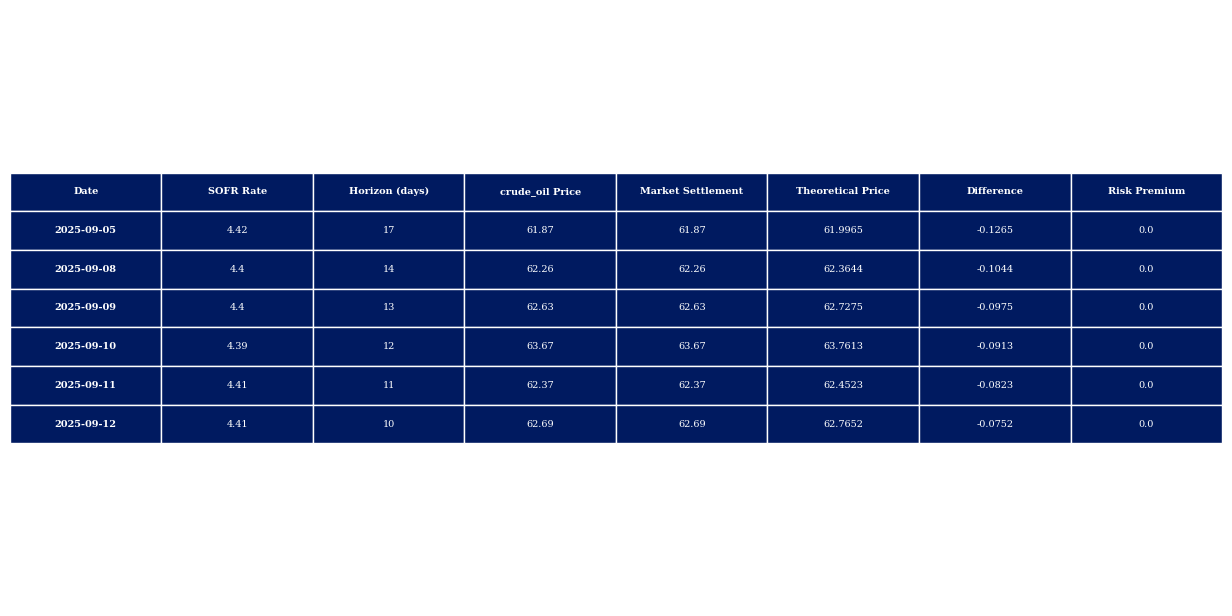

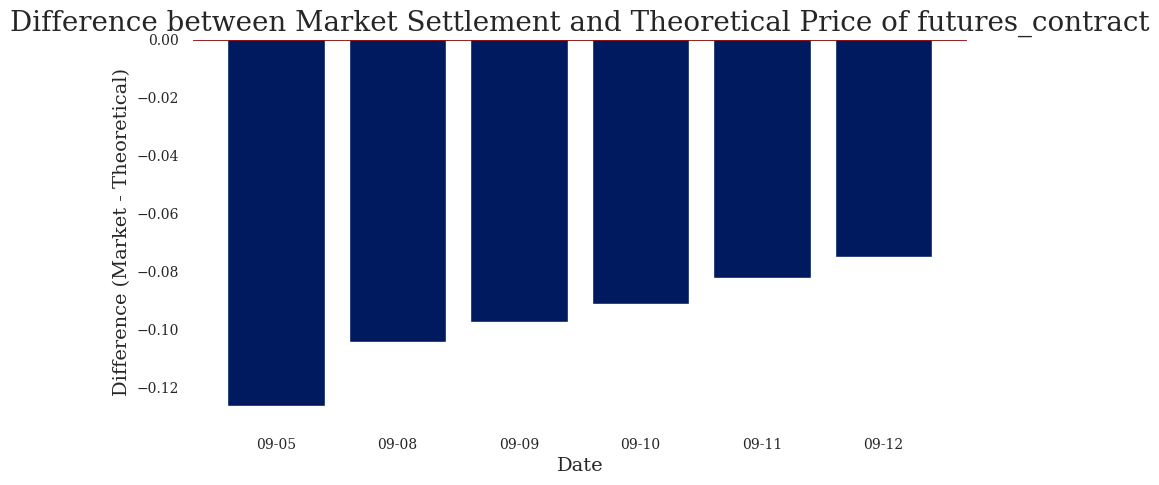

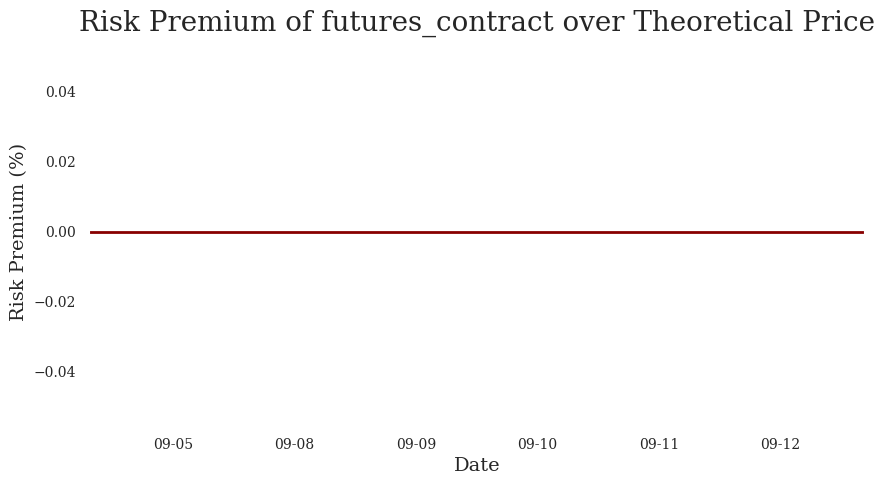

,SOFR Rate,Horizon (days),crude_oil Price,Market Settlement,Theoretical Price,Difference,Risk Premium
2025-09-05,4.42,17,61.87,61.87,61.996501,-0.126501,0.0
2025-09-08,4.40,14,62.26,62.26,62.364350,-0.104350,0.0
2025-09-09,4.40,13,62.63,62.63,62.727467,-0.097467,0.0
2025-09-10,4.39,12,63.67,63.67,63.761254,-0.091254,0.0
2025-09-11,4.41,11,62.37,62.37,62.452302,-0.082302,0.0
2025-09-12,4.41,10,62.69,62.69,62.765200,-0.075200,0.0


In [43]:
CRUDE_OIL = pricing_derivatives_in_time(SOFR, wti, "crude_oil", CLV25_settle, CLV25_expiration_date)
CRUDE_OIL

# IPC

## Futures Contract Price

In [44]:
# IPC Futures (IPCU25)
IPCU25_settle = [60814-92, 60814, 60759, 60685, 61614, 61758]
IPCU25_expiration_date = "2025-09-19"
IPCU25 = pd.Series(IPCU25_settle, index=dates)
IPCU25

2025-09-05    60722
2025-09-08    60814
2025-09-09    60759
2025-09-10    60685
2025-09-11    61614
2025-09-12    61758
dtype: int64

## Stock Price

In [45]:
import yfinance as yf


ipc = yf.download('^MXX', start='2020-01-01', end='2025-12-31')
ipc

C:\Users\herie\AppData\Local\Temp\ipykernel_30568\2632186628.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  ipc = yf.download('^MXX', start='2020-01-01', end='2025-12-31')
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,^MXX,^MXX,^MXX,^MXX,^MXX
Date,,,,,
2020-01-02,44437.230469,44521.519531,43716.488281,43739.519531,95180400
2020-01-03,44624.851562,44742.980469,44177.910156,44355.210938,103484500
2020-01-06,44495.300781,44571.738281,44287.128906,44489.968750,86928400
2020-01-07,44157.808594,44588.269531,44018.058594,44522.359375,137546300
2020-01-08,44470.910156,44515.988281,44078.410156,44160.550781,144629400
...,...,...,...,...,...
2025-09-09,60679.531250,60820.859375,60447.128906,60688.058594,172272600
2025-09-10,60489.191406,60987.351562,60431.628906,60643.140625,156040900


In [46]:
monthly_dividends_expected = 0.04

In [47]:
# Ensure IPCU25_expiration_date is a datetime object
IPCU25_expiration_date = pd.to_datetime(IPCU25_expiration_date)

# U in futures stands for the month of September

# Calculate days for expiration
days_for_expiration = (IPCU25_expiration_date - dates).days
days_for_expiration

Index([14, 11, 10, 9, 8, 7], dtype='int64')

In [48]:
expected_dividends = monthly_dividends_expected / 30 * days_for_expiration
expected_dividends = pd.Series(expected_dividends, index=dates)

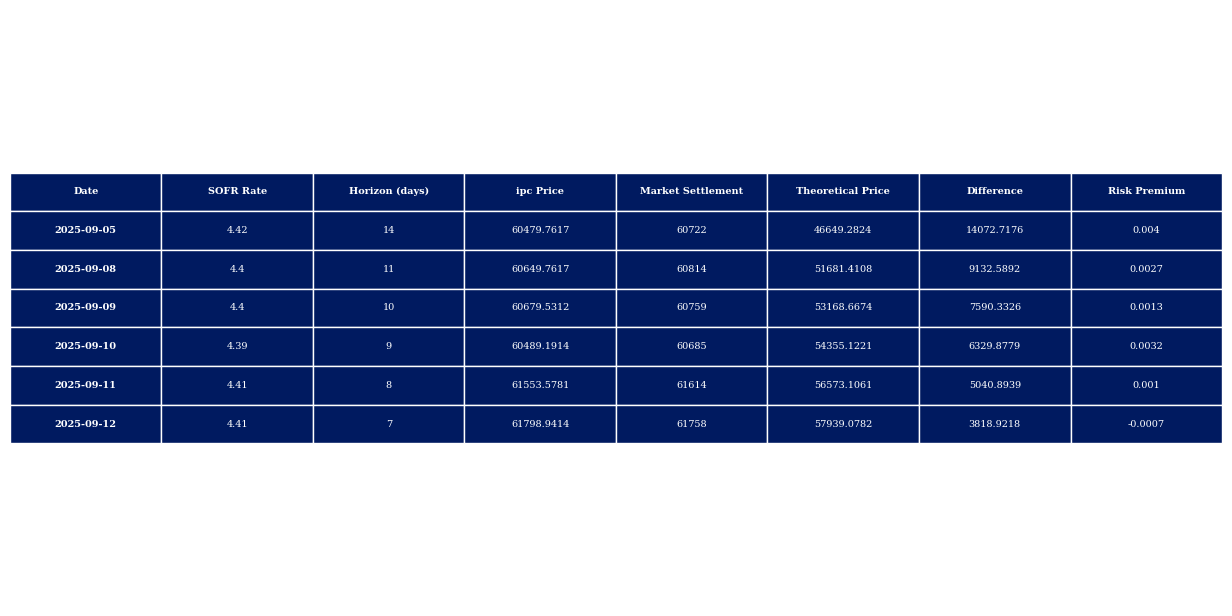

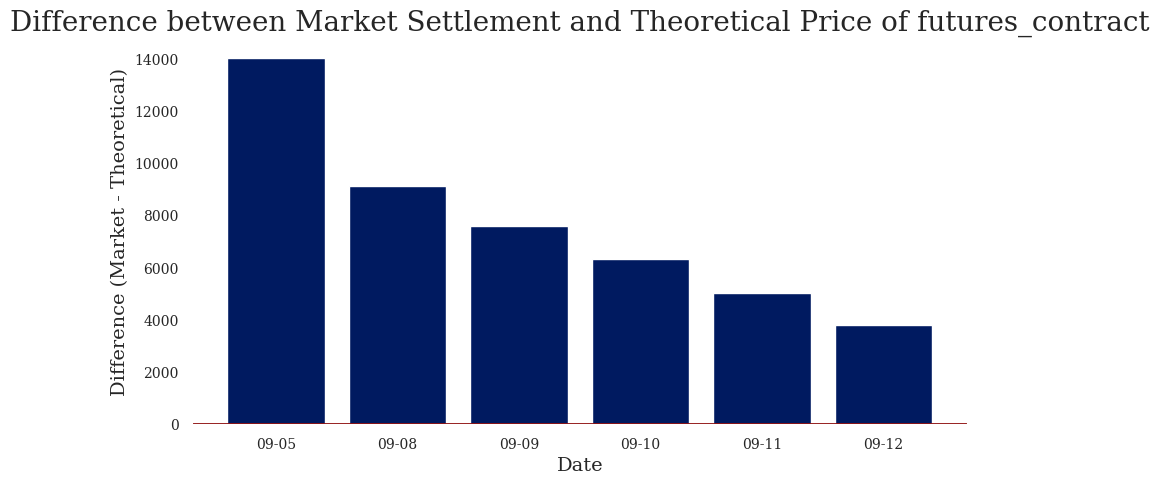

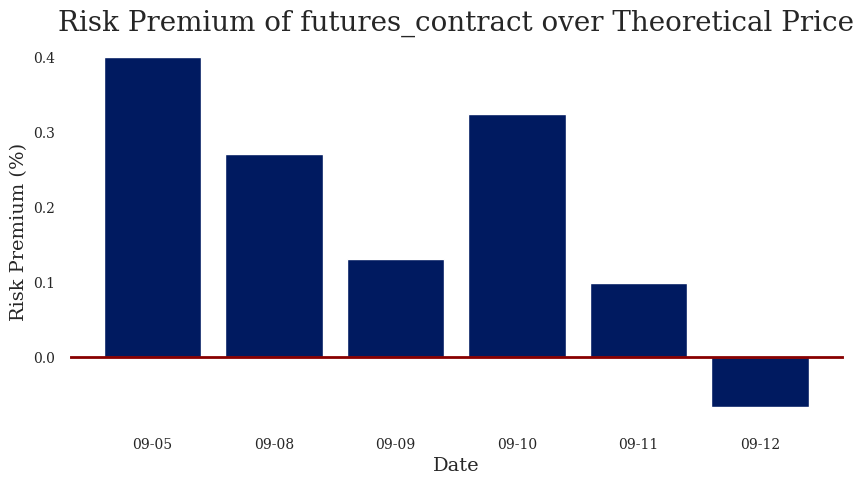

,SOFR Rate,Horizon (days),ipc Price,Market Settlement,Theoretical Price,Difference,Risk Premium
2025-09-05,4.42,14,60479.761719,60722,46649.282408,14072.717592,0.004005
2025-09-08,4.40,11,60649.761719,60814,51681.410836,9132.589164,0.002708
2025-09-09,4.40,10,60679.531250,60759,53168.667423,7590.332577,0.001310
2025-09-10,4.39,9,60489.191406,60685,54355.122058,6329.877942,0.003237
2025-09-11,4.41,8,61553.578125,61614,56573.106082,5040.893918,0.000982
2025-09-12,4.41,7,61798.941406,61758,57939.078173,3818.921827,-0.000662


In [49]:
IPC = pricing_derivatives_in_time(SOFR, ipc, "ipc", IPCU25_settle, IPCU25_expiration_date, expected_dividends)
IPC

# CORN

## Futures Contract Price

In [50]:
# Corn Futures (CZ25)
CZ25_settle = [4216-36, 4216, 4196, 4170, 4196, 4300]
CZ25_expiration_date = "2025-12-12"
CZ25 = pd.Series(CZ25_settle, index=dates)
CZ25

2025-09-05    4180
2025-09-08    4216
2025-09-09    4196
2025-09-10    4170
2025-09-11    4196
2025-09-12    4300
dtype: int64

## Spot Price

# TIIE

## Futures Contract Price

In [64]:
# TIIE Futures (TIEU26)
TIEU26_settle = [92.925-.07, 92.925, 92.955, 92.93, 92.965, 93.035]
TIEU26 = pd.Series(TIEU26_settle, index=dates)
TIEU26 

2025-09-05    92.855
2025-09-08    92.925
2025-09-09    92.955
2025-09-10    92.930
2025-09-11    92.965
2025-09-12    93.035
dtype: float64

In [65]:
TIEU26_expiration_date = "2026-09-30"
TIEU26_expiration_date = pd.to_datetime(TIEU26_expiration_date)
days_for_expiration = (TIEU26_expiration_date - dates).days
days_for_expiration = pd.Series(days_for_expiration, index=dates)
days_for_expiration

2025-09-05    390
2025-09-08    387
2025-09-09    386
2025-09-10    385
2025-09-11    384
2025-09-12    383
dtype: int64

## Spot Price

In [67]:
# read the Sheet1 from tiie.xlsx
tiie = pd.read_excel("tiie.xlsx", sheet_name="Sheet1", index_col=0, parse_dates=True)
tiie

,"TIIE a 28 días, Tasa de interés en por ciento anual"
Fecha,
2006-01-02,8.5700
2006-01-03,8.5650
2006-01-04,8.5500
2006-01-05,8.5650
2006-01-06,8.5750
...,...
2025-09-09,8.0126
2025-09-10,8.0126
2025-09-11,8.0126


In [68]:
tiie = tiie[tiie.index.isin(dates)]
tiie = pd.Series(tiie.iloc[:,0], index=tiie.index)
tiie

Fecha
2025-09-05    8.0226
2025-09-08    8.0226
2025-09-09    8.0126
2025-09-10    8.0126
2025-09-11    8.0126
2025-09-12    8.0126
Name: TIIE a 28 días, Tasa de interés en por ciento anual, dtype: float64

In [73]:
theoretical_price_tiie = 100 - 100*((1 + tiie/100/360) ** days_for_expiration-1)*360/days_for_expiration
theoretical_price_tiie

Fecha
2025-09-05    91.619424
2025-09-08    91.622265
2025-09-09    91.634107
2025-09-10    91.635051
2025-09-11    91.635995
2025-09-12    91.636939
dtype: float64

In [74]:
difference_tiie = TIEU26 - theoretical_price_tiie
difference_tiie

2025-09-05    1.235576
2025-09-08    1.302735
2025-09-09    1.320893
2025-09-10    1.294949
2025-09-11    1.329005
2025-09-12    1.398061
dtype: float64